### Investigating stylized facts of asset returns

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

2. Download the S&P 500 data and calculate the returns:

In [2]:
df = yf.download('^GSPC',
                start='1985-01-01',
                end='2018-12-31',
                progress=False)
df = df[['Adj Close']].rename(columns={'Adj Close':'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how='any')

### Fact 1- Non-Gaussian distribution of returns:

1. Calculate the normal PDF using the mean and standard deviation of the observed returns:

In [3]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

2. Plot the histogram and the Q-Q box

C:\Users\nking\AppData\Local\Temp\ipykernel_9916\968262984.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])


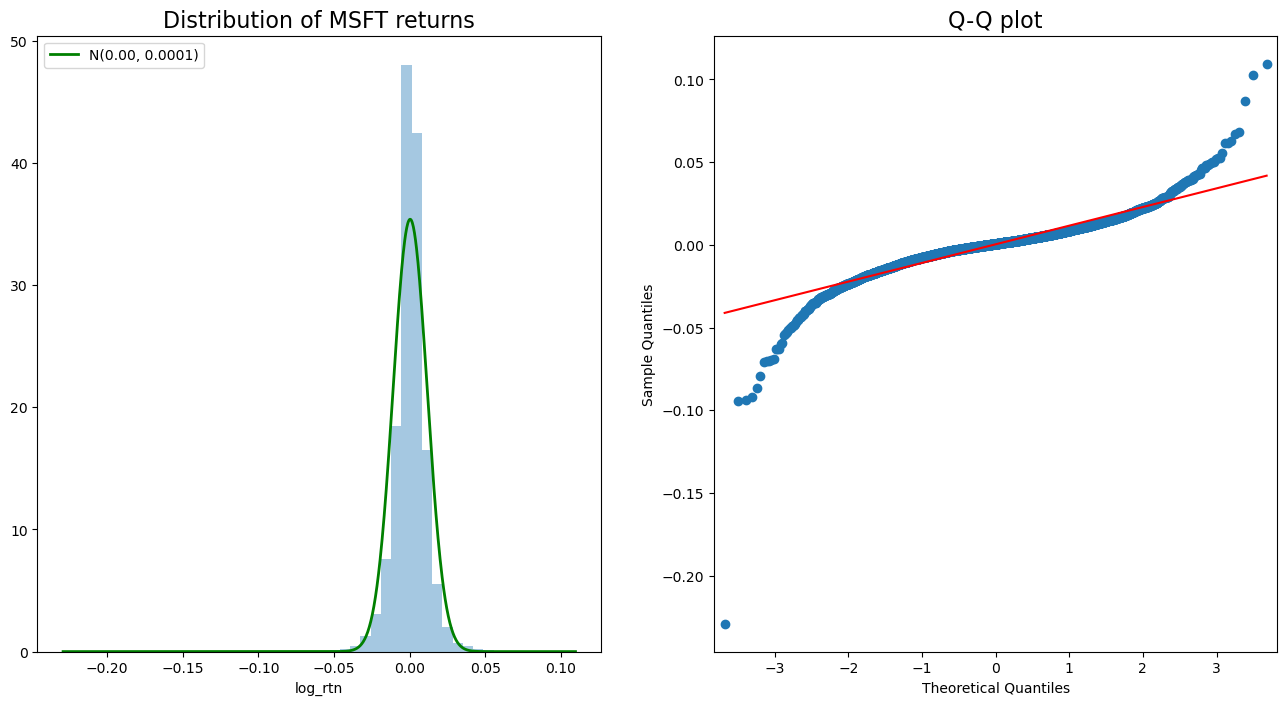

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

#histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of MSFT returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'g', lw=2,
          label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

# plt.tight_layout()
plt.show()

3. Print the summary statistics of the log returns:

In [5]:
jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 1985-01-03 - 2018-12-28
Number of observations: 8568
Mean: 0.0003
Median: 0.0006
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0113
Skewness: -1.2628
Kurtosis: 28.0156
Jarque-Bera statistic: 282134.38 with p-value: 0.00


#### Fact 2 - Volatility Clustering

1. Run the following code to visualize the log returns series:

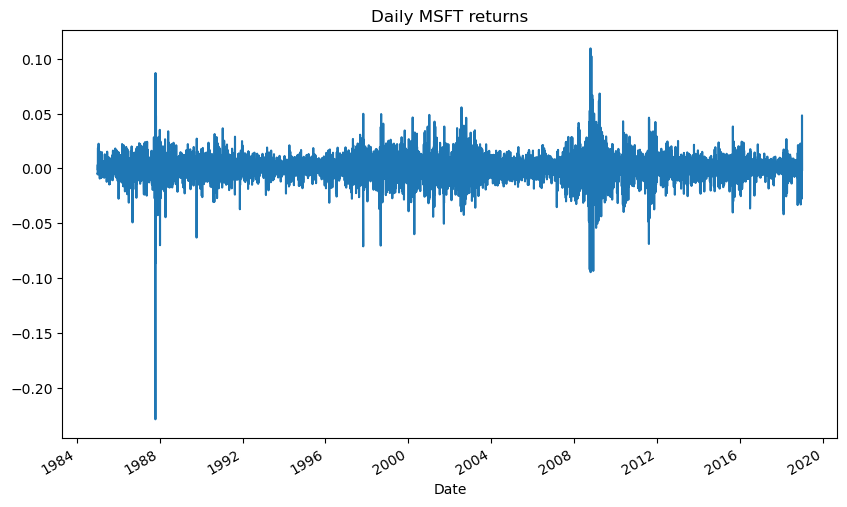

In [6]:
df.log_rtn.plot(title='Daily MSFT returns', figsize=(10, 6))

# plt.tight_layout()
plt.show()

#### Fact 3 - Absence of autocorrelation in returns

1. Define the parameters for creating the Autocorrelation plots:

In [7]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Run the following code to create ACF plot of log returns:

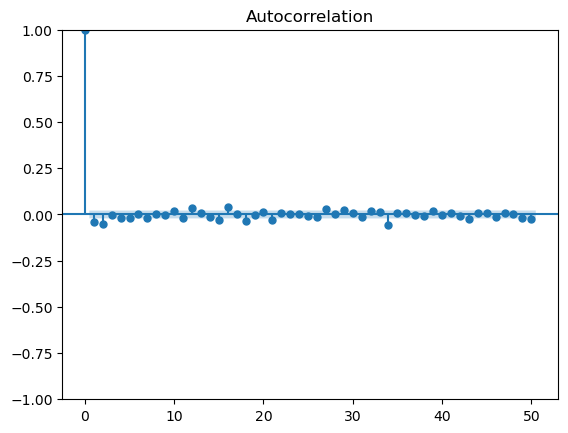

In [8]:
acf = smt.graphics.plot_acf(df.log_rtn, 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

#plt.tight_layout()
plt.show()

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

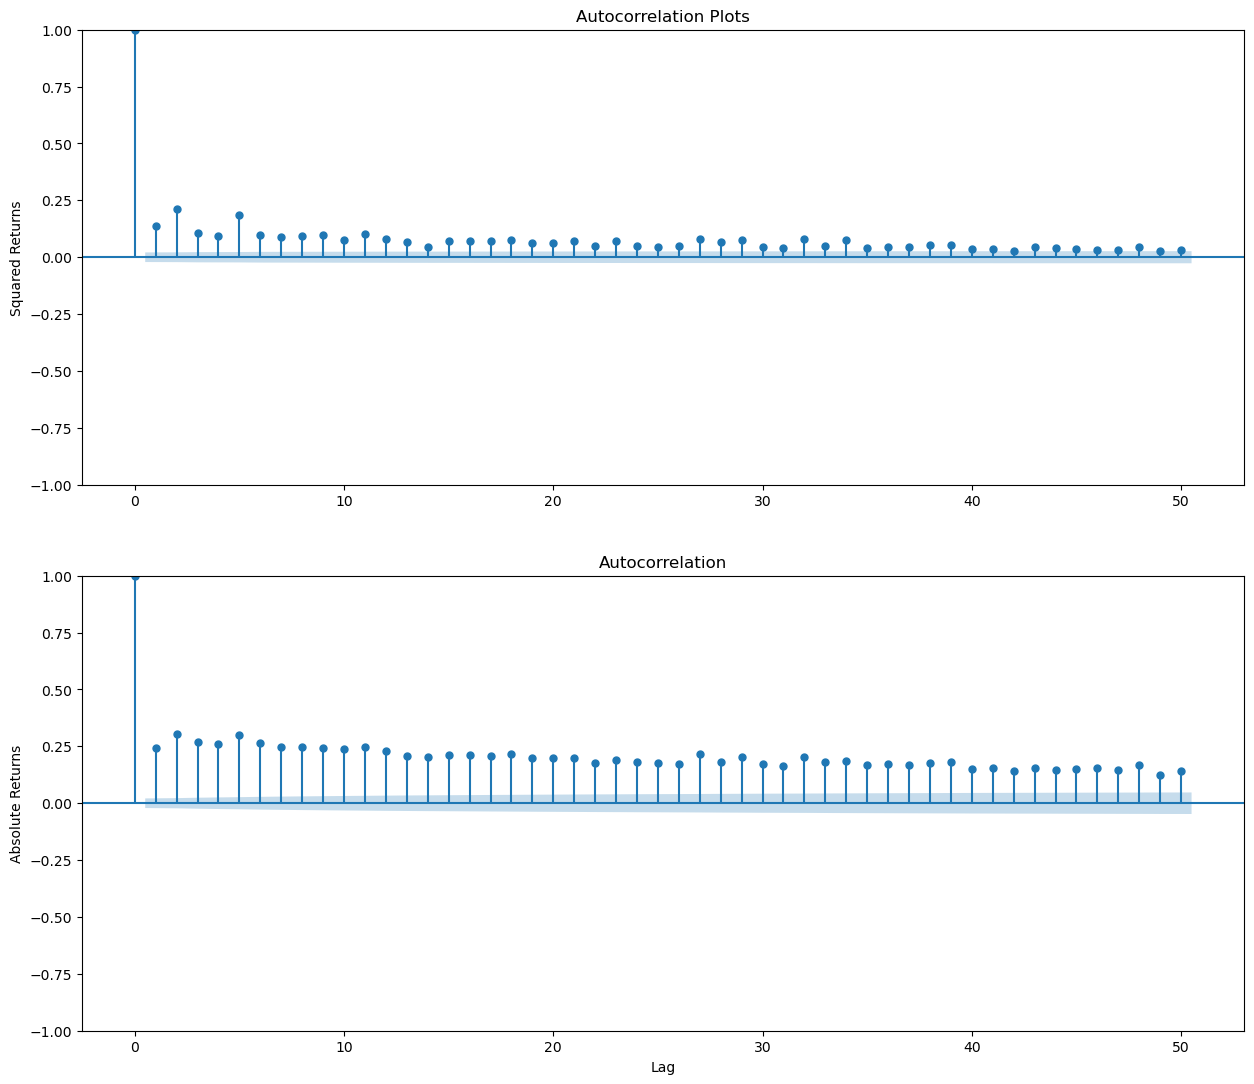

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(15, 13))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, 
                     alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots',
         ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, 
                     alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
         xlabel='Lag')

# plt.tight_layout()
plt.show()

### Fact 5: Leverage Effect

1. Calculate volatility measures as moving standard deviations:

In [10]:
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

2. Plot all the series:

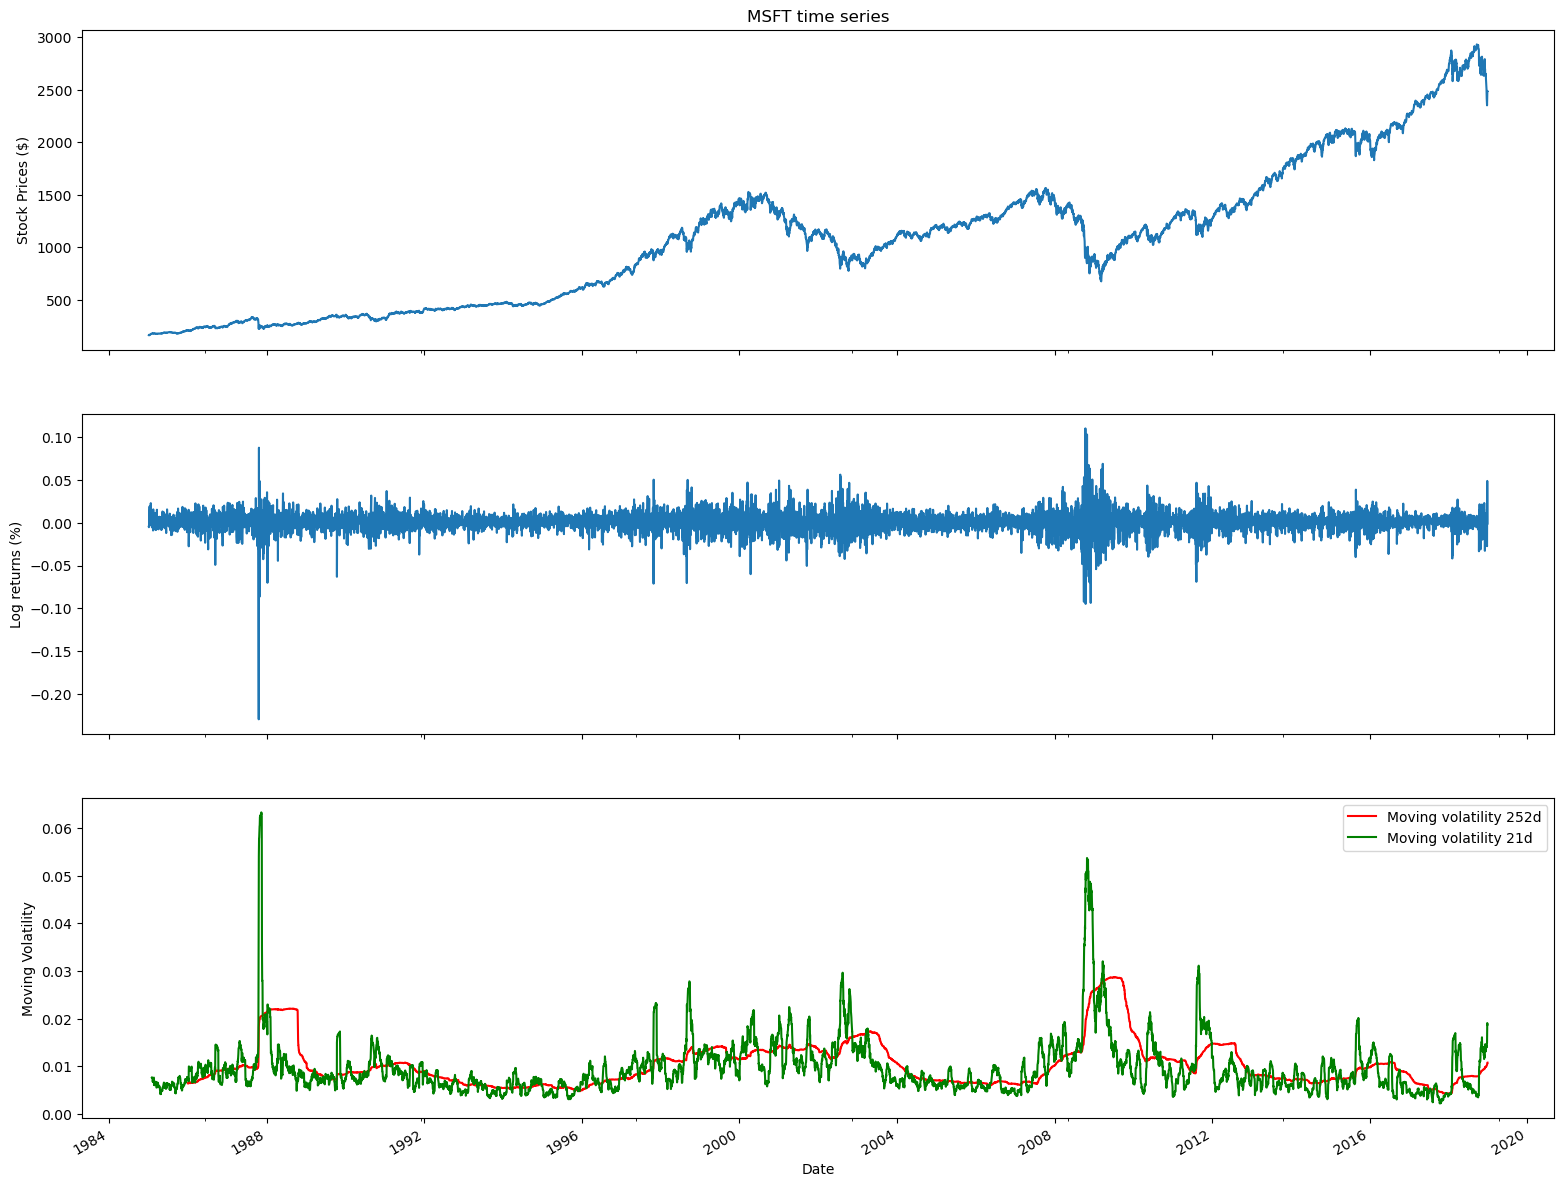

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(19, 16),
                      sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title='MSFT time series',
         ylabel='Stock Prices ($)')

df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log returns (%)')

df.moving_std_252.plot(ax=ax[2], color='r',
                       label='Moving volatility 252d')

df.moving_std_21.plot(ax=ax[2], color='g',
                     label='Moving volatility 21d')

ax[2].set(ylabel='Moving Volatility',
         xlabel='Date')
ax[2].legend()

#plot.tight_layout()
plt.show()

### There is more

1. Download and preprocess the prices of S&P 500 and VIX 

In [18]:
df= yf.download(['^GSPC', 'VIX'],
            start='1985-01-01',
            end='2018-12-31',
            progress=False)
df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df =df.rename(columns={'^GSPC':'sp500', 'VIX':'vix'})

2. Calculating the Log returns

In [19]:
df['log_rtn'] = np.log(df.sp500 / df.sp500.shift(1))
df['vol_rtn'] = np.log(df.vix / df.vix.shift(1))
df.dropna(how ='any', axis=0, inplace=True)

3. Plot a scatterplot with returns on axes and fit a regress line to identify trend:

In [ ]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax= sns.regplot(x='log_rtn', y='vol_rtn', data=df,
               line_kws=({'color':'red'})
ax.set(title=f'')